In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [3]:
from utils.helper import *

In [4]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

In [5]:
target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [7]:
# torch.Size([256, 5, 14]) -> [B, T, F]
# torch.Size([256])        -> [B]

class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)    # (B,)

In [8]:
lstm = BaselineLSTM(input_dim=len(features))

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [9]:
# Training the model using the train_loader, val_loader, and test_loader
lstm = lstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

num_epochs = 300
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/final_models/lstm5.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        # Create a temporary model to load and evaluate the existing model
        temp_lstm = BaselineLSTM(input_dim=len(features)).to(device)
        temp_lstm.load_state_dict(torch.load(existing_model_path))
        temp_lstm.eval()

        # Evaluate existing model on validation set
        existing_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = temp_lstm(batch_x)
                loss = criterion(outputs, batch_y)
                existing_val_loss += loss.item()

        existing_best_val_loss = existing_val_loss / len(val_loader)
        print(f"Existing model validation loss: {existing_best_val_loss:.6f}")

        # Delete temporary model to free memory
        del temp_lstm
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in lstm.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    lstm.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = lstm(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

# After training is complete, compare with existing model and save only if better
if best_val_loss < existing_best_val_loss:
    torch.save(lstm.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with validation loss: {best_val_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model validation loss: {best_val_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest validation loss achieved this training: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 33057
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 73.86it/s]


Epoch [1/300] - Train Loss: 1.023043, Val Loss: 17.949769
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 394.07it/s]


Epoch [2/300] - Train Loss: 0.835432, Val Loss: 16.686551
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 419.81it/s]


Epoch [3/300] - Train Loss: 0.674894, Val Loss: 15.120496
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 453.93it/s]


Epoch [4/300] - Train Loss: 0.551653, Val Loss: 13.207538
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 237.70it/s]


Epoch [5/300] - Train Loss: 0.458269, Val Loss: 10.958428
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 381.47it/s]


Epoch [6/300] - Train Loss: 0.364892, Val Loss: 8.708416
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 315.27it/s]


Epoch [7/300] - Train Loss: 0.287904, Val Loss: 6.877429
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 316.40it/s]


Epoch [8/300] - Train Loss: 0.220223, Val Loss: 5.456950
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 404.11it/s]


Epoch [9/300] - Train Loss: 0.170163, Val Loss: 4.262471
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 436.57it/s]


Epoch [10/300] - Train Loss: 0.131615, Val Loss: 3.233456
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 403.98it/s]


Epoch [11/300] - Train Loss: 0.101984, Val Loss: 2.452191
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 406.50it/s]


Epoch [12/300] - Train Loss: 0.080568, Val Loss: 1.889680
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 382.48it/s]


Epoch [13/300] - Train Loss: 0.065677, Val Loss: 1.463307
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 419.28it/s]


Epoch [14/300] - Train Loss: 0.055284, Val Loss: 1.201982
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 202.92it/s]


Epoch [15/300] - Train Loss: 0.047124, Val Loss: 1.007677
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.77it/s]


Epoch [16/300] - Train Loss: 0.040959, Val Loss: 0.896850
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 122.56it/s]


Epoch [17/300] - Train Loss: 0.037512, Val Loss: 0.765965
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 334.83it/s]


Epoch [18/300] - Train Loss: 0.040783, Val Loss: 0.773722
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 416.85it/s]


Epoch [19/300] - Train Loss: 0.049560, Val Loss: 0.584832
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 422.30it/s]


Epoch [20/300] - Train Loss: 0.036668, Val Loss: 0.808042
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 396.83it/s]


Epoch [21/300] - Train Loss: 0.024091, Val Loss: 0.621806
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.93it/s]


Epoch [22/300] - Train Loss: 0.021467, Val Loss: 0.618661
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 209.30it/s]


Epoch [23/300] - Train Loss: 0.020214, Val Loss: 0.627676
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.33it/s]


Epoch [24/300] - Train Loss: 0.018314, Val Loss: 0.539766
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 436.86it/s]


Epoch [25/300] - Train Loss: 0.016323, Val Loss: 0.546970
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 265.29it/s]


Epoch [26/300] - Train Loss: 0.014694, Val Loss: 0.505173
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 423.99it/s]


Epoch [27/300] - Train Loss: 0.013992, Val Loss: 0.505311
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.68it/s]


Epoch [28/300] - Train Loss: 0.013077, Val Loss: 0.467502
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 378.70it/s]


Epoch [29/300] - Train Loss: 0.012956, Val Loss: 0.482518
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 434.71it/s]


Epoch [30/300] - Train Loss: 0.013680, Val Loss: 0.435565
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 403.32it/s]


Epoch [31/300] - Train Loss: 0.017062, Val Loss: 0.507127
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 375.31it/s]


Epoch [32/300] - Train Loss: 0.026086, Val Loss: 0.429301
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 416.16it/s]


Epoch [33/300] - Train Loss: 0.021696, Val Loss: 0.648749
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 218.48it/s]


Epoch [34/300] - Train Loss: 0.015039, Val Loss: 0.434867
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 196.47it/s]


Epoch [35/300] - Train Loss: 0.010884, Val Loss: 0.549409
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 388.96it/s]


Epoch [36/300] - Train Loss: 0.009318, Val Loss: 0.489071
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 313.58it/s]


Epoch [37/300] - Train Loss: 0.008563, Val Loss: 0.471721
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 393.39it/s]


Epoch [38/300] - Train Loss: 0.007852, Val Loss: 0.454473
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 425.45it/s]


Epoch [39/300] - Train Loss: 0.008189, Val Loss: 0.431910
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 430.67it/s]


Epoch [40/300] - Train Loss: 0.007408, Val Loss: 0.424584
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 418.49it/s]


Epoch [41/300] - Train Loss: 0.007571, Val Loss: 0.420462
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 441.32it/s]


Epoch [42/300] - Train Loss: 0.007024, Val Loss: 0.419098
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.60it/s]


Epoch [43/300] - Train Loss: 0.007588, Val Loss: 0.420285
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 221.63it/s]


Epoch [44/300] - Train Loss: 0.007249, Val Loss: 0.387600
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 228.16it/s]


Epoch [45/300] - Train Loss: 0.008083, Val Loss: 0.407788
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 414.44it/s]


Epoch [46/300] - Train Loss: 0.010403, Val Loss: 0.394667
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 412.38it/s]


Epoch [47/300] - Train Loss: 0.012576, Val Loss: 0.473159
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 208.13it/s]


Epoch [48/300] - Train Loss: 0.018971, Val Loss: 0.409769
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 188.90it/s]


Epoch [49/300] - Train Loss: 0.016019, Val Loss: 0.603341
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 201.82it/s]


Epoch [50/300] - Train Loss: 0.012411, Val Loss: 0.398278
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 454.52it/s]


Epoch [51/300] - Train Loss: 0.008208, Val Loss: 0.509521
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 435.82it/s]


Epoch [52/300] - Train Loss: 0.006862, Val Loss: 0.408167
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 440.62it/s]


Epoch [53/300] - Train Loss: 0.006169, Val Loss: 0.422873
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 425.62it/s]


Epoch [54/300] - Train Loss: 0.005968, Val Loss: 0.384732
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 347.35it/s]


Epoch [55/300] - Train Loss: 0.005870, Val Loss: 0.385594
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 443.96it/s]


Epoch [56/300] - Train Loss: 0.005981, Val Loss: 0.366492
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 223.82it/s]


Epoch [57/300] - Train Loss: 0.005502, Val Loss: 0.367195
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 400.07it/s]


Epoch [58/300] - Train Loss: 0.005633, Val Loss: 0.358638
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 389.95it/s]


Epoch [59/300] - Train Loss: 0.005459, Val Loss: 0.357094
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 211.64it/s]


Epoch [60/300] - Train Loss: 0.006231, Val Loss: 0.351804
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 379.15it/s]


Epoch [61/300] - Train Loss: 0.007016, Val Loss: 0.364129
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.04it/s]


Epoch [62/300] - Train Loss: 0.008941, Val Loss: 0.357756
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.82it/s]


Epoch [63/300] - Train Loss: 0.011089, Val Loss: 0.407228
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 378.21it/s]


Epoch [64/300] - Train Loss: 0.015089, Val Loss: 0.393895
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 229.78it/s]


Epoch [65/300] - Train Loss: 0.013488, Val Loss: 0.488410
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.75it/s]


Epoch [66/300] - Train Loss: 0.012156, Val Loss: 0.370567
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 338.69it/s]


Epoch [67/300] - Train Loss: 0.009340, Val Loss: 0.479163
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 422.83it/s]


Epoch [68/300] - Train Loss: 0.008111, Val Loss: 0.381785
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.17it/s]


Epoch [69/300] - Train Loss: 0.006544, Val Loss: 0.418691
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.14it/s]

Epoch [70/300] - Train Loss: 0.006237, Val Loss: 0.360700
Early stopping triggered after epoch 70

New model is better! Saved with validation loss: 0.351804
Previous best was: inf

Best validation loss achieved this training: 0.351804


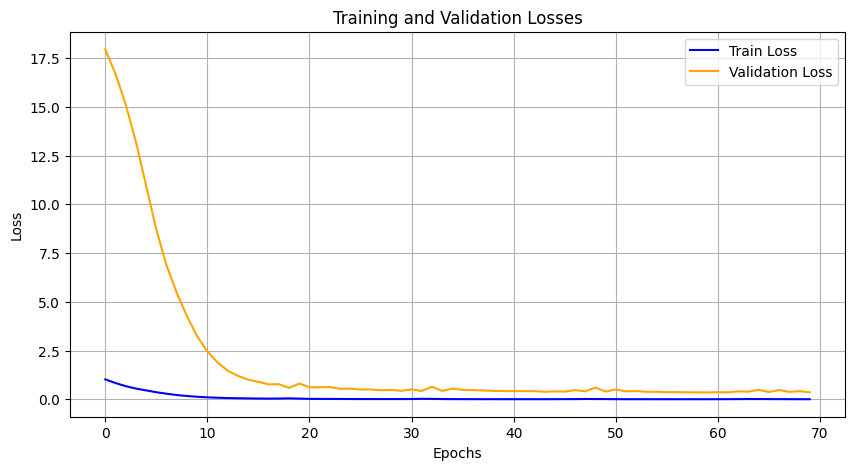

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [11]:
lstm.load_state_dict(torch.load('../../models/final_models/lstm5.pth'))

<All keys matched successfully>

In [12]:
# Test phase
lstm.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.176935


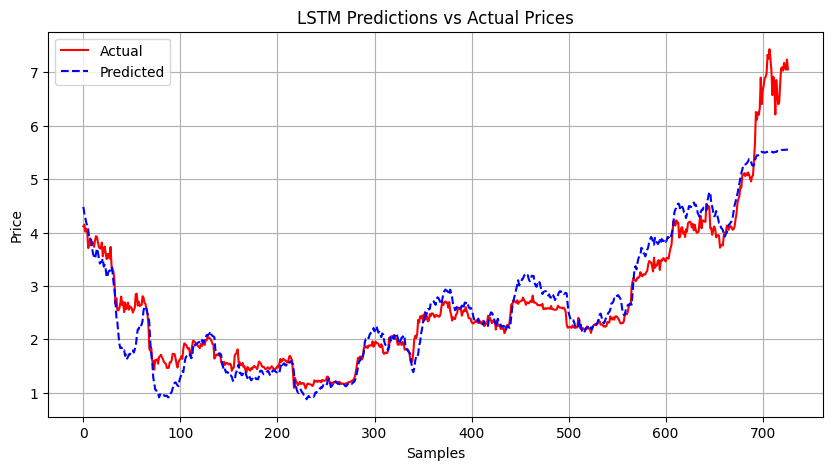

In [13]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()